In [42]:
import globus_sdk
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D

In [43]:
""" Read Files into DataFrame objects """

data = pd.read_csv("test.csv") # reads comma delimited file into a DataFrame object
off_campus = pd.read_csv("offcampus_data.csv")
on_campus = pd.read_csv("oncampus_data.csv")
# Preview the first 5 lines of the loaded data 
data.head(16) # returns the first n rows of the DataFrame, n here is 16

,Dataset,Start,End,Elapsed,Speed,Source EP ID,Dest. EP ID,Task ID
0,ds01,2020-12-15T03:16:17+00:00,2020-12-15T03:16:31+00:00,0:00:13.948828,6.83,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,e4db46d6-3e83-11eb-b559-02d9497ca481
1,ds04,2020-12-15T03:16:31+00:00,2020-12-15T03:16:54+00:00,0:00:23.533417,411.39,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,ed4bfb80-3e83-11eb-b559-02d9497ca481
2,ds06,2020-12-15T03:16:55+00:00,2020-12-15T03:20:09+00:00,0:03:13.832365,491.98,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,fb776488-3e83-11eb-b559-02d9497ca481
3,ds08,2020-12-15T03:20:09+00:00,2020-12-15T03:46:26+00:00,0:26:17.256435,621.78,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,6f31a0c8-3e84-11eb-b181-0ee0d5d9299f
4,ds10,2020-12-15T03:46:26+00:00,2020-12-15T04:10:47+00:00,0:24:20.822792,653.01,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,1b813fca-3e88-11eb-b181-0ee0d5d9299f
5,ds12,2020-12-15T04:10:48+00:00,2020-12-15T04:15:05+00:00,0:04:17.624449,370.59,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,8264d6a4-3e8b-11eb-b181-0ee0d5d9299f
6,ds14,2020-12-15T04:15:05+00:00,2020-12-15T06:16:39+00:00,2:01:33.838759,653.78,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,1c2106b4-3e8c-11eb-b559-02d9497ca481
7,ds16,2020-12-15T06:16:40+00:00,2020-12-15T06:41:04+00:00,0:24:24.777208,651.11,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,17bfb12c-3e9d-11eb-8fed-0a34088e79f9
8,ds01,2020-12-15T06:41:05+00:00,2020-12-15T06:42:00+00:00,0:00:55.646277,1.72,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,80f7d874-3ea0-11eb-b55a-02d9497ca481
9,ds04,2020-12-15T06:42:01+00:00,2020-12-15T06:43:17+00:00,0:01:16.523024,124.72,9c8c88c2-ea4a-11e6-b9ba-22000b9a448b,606579ae-5b03-11e9-bf32-0edbf3a4e7ee,a24ffb50-3ea0-11eb-b181-0ee0d5d9299f


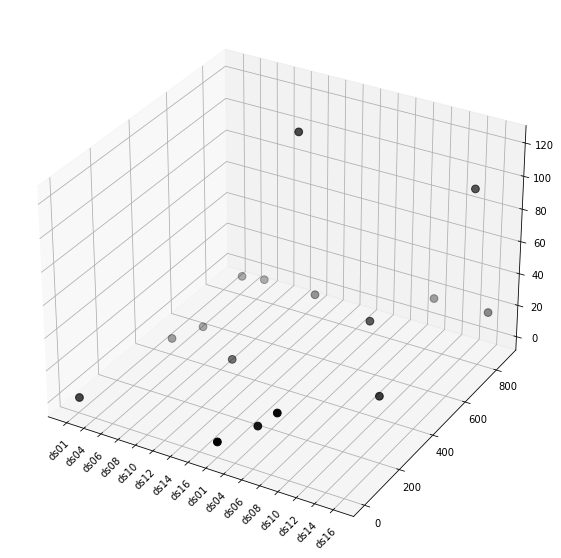

In [44]:
""" Builds a 3D plot based on the elapsed time values using pandas and matplotlib """

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(range(len(data['Dataset'])), data['Speed'],(pd.to_datetime(data['End'], infer_datetime_format=True) - pd.to_datetime(data['Start'], infer_datetime_format=True)).dt.total_seconds() / 60,  c='black', s=60)
ax.set(xticks=range(len(data['Dataset'])), xticklabels=data['Dataset'])
plt.xticks(rotation=45)
plt.show()


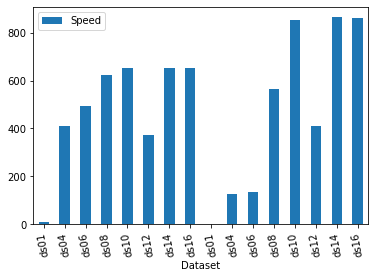

In [76]:
""" Builds bar graphs to represent data for different endpoints """

#plot
bg1 = data.plot.bar(x = 'Dataset', y = 'Speed', rot = 100) # graph shows the speed for each ds

In [79]:
""" Builds bar graphs to represent data for different endpoints """

#time = (pd.to_datetime(data['End'], infer_datetime_format=True) - pd.to_datetime(data['Start']
bg2 = data.plot.bar(x = 'Dataset', y = (pd.to_datetime(data['End'], infer_datetime_format=True) - pd.to_datetime(data['Start'], rot=100)


SyntaxError: unexpected EOF while parsing (<ipython-input-79-0e9902f99aeb>, line 4)

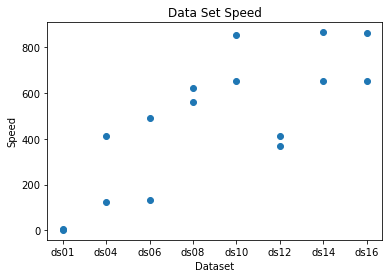

In [73]:
""" Builds scatter plots to represent data for different endpoints """

plt.scatter((data['Dataset']), data['Speed'])
plt.title('Data Set Speed')
plt.xlabel('Dataset')
plt.ylabel('Speed')
plt.show()

In [24]:
"""File parse
ds_sizes = {'ds01': 0.1, 'ds04':10, 'ds06':100, 'ds08': 1000, 'ds10': 1000, 'ds12':100, 
            'ds14': 5000, 'ds16': 1000} # sizes given in gigabytes

ds_names = ['ds01', 'ds04', 'ds06', 'ds08', 'ds10', 'ds12', 
            'ds14', 'ds16']

src_to_oncampx = []
src_to_oncampy = []
oncampx_to_src = []
oncampy_to_src= []

src_to_offcampx = []
src_to_offcampy = []
offcampx_to_src = []
offcampy_to_src= []

num_rows = 0
with open('oncampus_data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        try:
            if (row[0][0] == "d") and (row[0][1] == 's'):
                
                if num_rows < 8: # distinguishes transfers from source to UAB.
                    src_to_oncampx.append(ds_sizes.get(row[0]))
                    src_to_oncampy.append(float(row[3]))
                    
                if num_rows >= 8: # distinguishes transfers from UAB to source.
                    oncampx_to_src.append(ds_sizes.get(row[0]))
                    oncampy_to_src.append(float(row[3]))
            
            num_rows += 1
            
        except IndexError:
            # blank text will have been caught here
            pass
    

num_rows = 0
with open('offcampus_data.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        try:
            if (row[0][0] == "d") and (row[0][1] == 's'):
                
                if num_rows < 8: # distinguishes transfers remote to local 
                    src_to_offcampx.append(ds_sizes.get(row[0]))
                    src_to_offcampy.append(float(row[3]))
                    
                if num_rows >= 8: # distinguishes transfers local to remote. 
                    offcampx_to_src.append(ds_sizes.get(row[0]))
                    offcampy_to_src.append(float(row[3]))
            
            num_rows += 1
            
        except IndexError:
            # blank text will have been caught here
            pass
"""

'File parse\nds_sizes = {\'ds01\': 0.1, \'ds04\':10, \'ds06\':100, \'ds08\': 1000, \'ds10\': 1000, \'ds12\':100, \n            \'ds14\': 5000, \'ds16\': 1000} # sizes given in gigabytes\n\nds_names = [\'ds01\', \'ds04\', \'ds06\', \'ds08\', \'ds10\', \'ds12\', \n            \'ds14\', \'ds16\']\n\nsrc_to_oncampx = []\nsrc_to_oncampy = []\noncampx_to_src = []\noncampy_to_src= []\n\nsrc_to_offcampx = []\nsrc_to_offcampy = []\noffcampx_to_src = []\noffcampy_to_src= []\n\nnum_rows = 0\nwith open(\'oncampus_data.csv\',\'r\') as csvfile:\n    plots = csv.reader(csvfile, delimiter=\',\')\n    for row in plots:\n        try:\n            if (row[0][0] == "d") and (row[0][1] == \'s\'):\n                \n                if num_rows < 8: # distinguishes transfers from source to UAB.\n                    src_to_oncampx.append(ds_sizes.get(row[0]))\n                    src_to_oncampy.append(float(row[3]))\n                    \n                if num_rows >= 8: # distinguishes transfers from UAB to

In [6]:
""""
x = np.arange(len(ds_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(2, 1)
# fig.set_figheight(4)
fig.figsize()

rects1 = ax[0].bar(x - width/2, src_to_oncampy, width, label='Source > OnCampus')
rects2 = ax[0].bar(x + width/2, oncampy_to_src, width, label='OnCampus > Source')

rects3 = ax[1].bar(x - width/2, src_to_offcampy, width, label='Source > OffCampus')
rects4 = ax[1].bar(x + width/2, offcampy_to_src, width, label='OffCampus > Source')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Speed (MB/s)')
ax[0].set_title('DTN Comparison to and from OnCampus Endpoint')
ax[0].set_xticks(x)
ax[0].set_xticklabels(ds_names)
ax[0].legend()

ax[1].set_ylabel('Speed (MB/s)')
ax[1].set_title('DTN Comparison to and from OffCampus Endpoint')
ax[1].set_xticks(x)
ax[1].set_xticklabels(ds_names)
ax[1].legend()

def autolabel(rects, num):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[num].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, 0)
autolabel(rects2, 0)

autolabel(rects3, 1)
autolabel(rects4, 1)

fig.tight_layout()

plt.show()
""""

NameError: name 'ds_names' is not defined